# 机器学习工作文件
## 所有机器学习，seed一律设置为3，确保结果可复现
### chunk可能有pre和after，pre-主要做特殊的数据重清洗，从简单清洗的大表中提出需要的数据并作更精细清洗，after-主要做参数寻优。

chunk1:线性回归
chunk2:K近邻回归
chunk3:svm回归
chunk4:决策树
chunk5:Bagging
chunk6:RandomForest
chunk7:AdaBoost
chunk8:XGBoost
chunk9:GradientBoost
chunk10:Stacking

In [5]:

#import和读取数据
import time
from sklearn.model_selection import RandomizedSearchCV
import pipreqs
import numpy as np
import pandas as pd
import graphviz
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.neighbors import KNeighborsRegressor
from sklearn import preprocessing   #数据预处理
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import scipy.stats as stats

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression #逻辑回归（分段）
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.ensemble import BaggingRegressor,RandomForestRegressor,AdaBoostRegressor,GradientBoostingRegressor,StackingRegressor
from sklearn.linear_model import LinearRegression,Ridge
from sklearn.svm import SVR
from xgboost import XGBRegressor
import os
import sklearn.svm as svm
import sklearn.metrics as sm
import statsmodels.api as stm
import graphviz
#import shap
from scipy.stats import randint

data = pd.read_csv('..\data_related/data/mid_data/exclude0_data_filtered.csv')

In [3]:
#调用函数(需要先运行chunk1的数据清洗和相关的函数定义chunk)，此处方便开发完成后检视成果

#linreg()
#knr(k=10,testsize=0.1,seed=3)


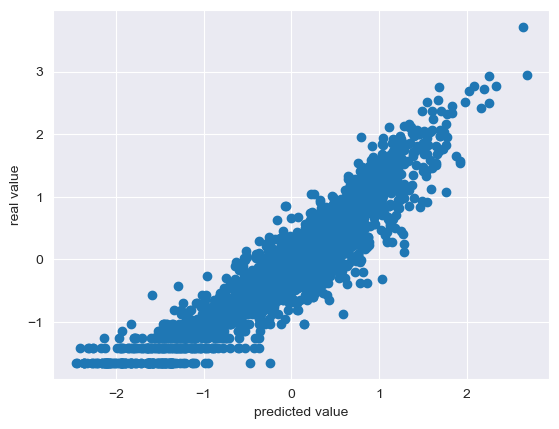

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           nor_back_num   R-squared:                       0.866
Model:                            OLS   Adj. R-squared:                  0.866
Method:                 Least Squares   F-statistic:                     4100.
Date:                Sat, 22 Oct 2022   Prob (F-statistic):               0.00
Time:                        13:57:13   Log-Likelihood:                -791.00
No. Observations:                1909   AIC:                             1590.
Df Residuals:                    1905   BIC:                             1612.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          1.557e-16      0.008   1.86e-14      1.000      -0.016       0.016
nor_pledge_goal       0.2971      0.020     15.069      0.000       0.258       0.336
nor_money_pledged     0.4028      0.030     13.444      0.000       0.344       0.462
nor_pledge_ratio      0.5456      0.030     18.233      0.000       0.487       0.604
==============================================================================
Omnibus:                       24.806   Durbin-Watson:                   1.765
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               27.738
Skew:                          -0.227   Prob(JB):                     9.48e-07
Kurtosis:                       3.378   Cond. No.                         7.25
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [29]:
#chunk1:线性回归
def linreg():
    """
    连续视角下线性回归
    :return: 类型为method 内容为拟合的统计结果与参数

    """
    x=data[['nor_pledge_ratio','nor_money_pledged','nor_pledge_goal']]
    y=data['nor_back_num']

    fit=stm.formula.ols('nor_back_num~nor_pledge_goal+nor_money_pledged+nor_pledge_ratio',data=data).fit()
    predicts=fit.predict()
    plt.scatter(predicts,y)
    plt.xlabel('predicted value')
    plt.ylabel('real value')
    plt.show()
    return fit.summary()

linreg()



('k近邻回归',
 'uni算法训练集R-square: 0.899419861110612',
 'uni算法测试集R-square: 0.8958118953706514',
 'dis算法训练集R-square: 0.9996291285055238',
 'dis算法测试集R-square: 0.8870204375119906')

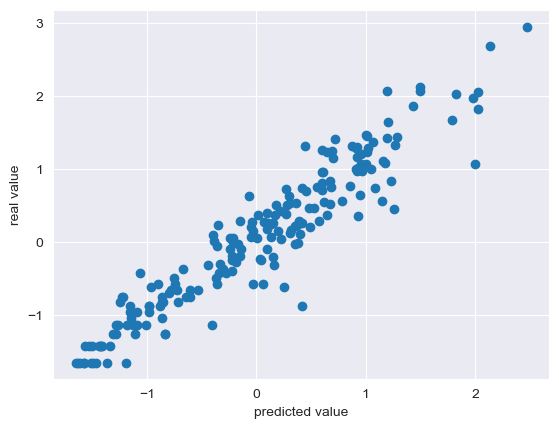

In [30]:
#chunk2:K近邻回归
def knr(k=10,testsize=0.4,seed=3):
    """
    k最近邻回归
    :param k: int 聚类个数 可寻优
    :param test_size: float 测试集比例 可寻优
    :param seed: num 提供随机数种子
    :return:
    """
    x=data[['nor_pledge_ratio','nor_money_pledged','nor_pledge_goal']]
    y=data['nor_back_num']
    x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=testsize,random_state=seed)

    #平均距离法
    uni_knr=KNeighborsRegressor(n_neighbors=k,weights='uniform')
    uni_knr.fit(x_train,y_train)
    uni_knr_y_predict=uni_knr.predict(x_test)

    #加权距离法
    dis_knr=KNeighborsRegressor(n_neighbors=k,weights='distance')
    dis_knr.fit(x_train,y_train)
    dis_knr_y_predict=dis_knr.predict(x_test)

    #输出r-square
    a='uni算法训练集R-square: '+str(uni_knr.score(x_train,y_train))
    b='uni算法测试集R-square: '+str(uni_knr.score(x_test,y_test))
    c='dis算法训练集R-square: '+str(dis_knr.score(x_train,y_train))
    d='dis算法测试集R-square: '+str(dis_knr.score(x_test,y_test))
    plt.scatter(uni_knr_y_predict,y_test)
    plt.xlabel('predicted value')
    plt.ylabel('real value')
    return 'k近邻回归',a,b,c,d

knr(k=12,testsize=0.1,seed=3)


In [31]:
#after-chunk2：k近邻回归参数调优
time_start=time.time()
x=data[['nor_pledge_ratio','nor_money_pledged','nor_pledge_goal']]
y=data['nor_back_num']
seed=3

#二维网格
list_k=range(2,51,2)
list_testsize=list(np.array(range(1,5,1))/10)

#重复测试
for k in list_k:
    for testsize in list_testsize:
        x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=testsize,random_state=seed)
        #平均距离法
        uni_knr=KNeighborsRegressor(n_neighbors=k,weights='uniform')
        uni_knr.fit(x_train,y_train)
        uni_knr_y_predict=uni_knr.predict(x_test)
        print('\nk,testsize: '+str(k)+','+str(testsize)+str(uni_knr.score(x_test,y_test)))

print('训练用时'+str(time.time()-time_start))




k,testsize: 2,0.10.8489746414841927

k,testsize: 2,0.20.8503155768063619

k,testsize: 2,0.30.8417376251823715

k,testsize: 2,0.40.836045505586672

k,testsize: 4,0.10.8709801727275286

k,testsize: 4,0.20.8660128886616567

k,testsize: 4,0.30.8661720052513143

k,testsize: 4,0.40.8618326974556381

k,testsize: 6,0.10.8828277035746799

k,testsize: 6,0.20.8731947137440061

k,testsize: 6,0.30.8793550044230322

k,testsize: 6,0.40.8738240963087388

k,testsize: 8,0.10.8898110730356825

k,testsize: 8,0.20.8775243662388301

k,testsize: 8,0.30.8817576425397345

k,testsize: 8,0.40.8798004679648329

k,testsize: 10,0.10.8929569414512606

k,testsize: 10,0.20.8836004712256793

k,testsize: 10,0.30.8848982829396859

k,testsize: 10,0.40.8808834483408887

k,testsize: 12,0.10.8958118953706514

k,testsize: 12,0.20.8816406141932852

k,testsize: 12,0.30.8861206506997882

k,testsize: 12,0.40.883741889147714

k,testsize: 14,0.10.892587944207218

k,testsize: 14,0.20.8811857622742173

k,testsize: 14,0.30.8866700573

('svm回归', '训练集R-square: 0.897236451772327', '测试集R-square: 0.9079525303882683')

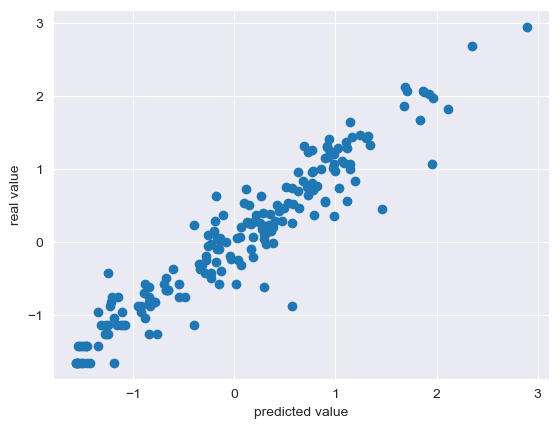

In [32]:
#chunk3:svm回归

import sklearn.preprocessing as sp
import sklearn.model_selection as ms
import sklearn.svm as svm

def svmreg(kernel='rbf',C=10,gamma=1,testsize=0.2,seed=3):
    """"""

    x=data[['nor_pledge_ratio','nor_money_pledged','nor_pledge_goal']]
    y=data['nor_back_num']

    # 拆分测试集 训练集
    x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=testsize,random_state=seed)

    # 创建模型, 模型训练
    model = svm.SVR(kernel=kernel, C=C,gamma=gamma) #较小的 C 会使决策表面更平滑，同时较高的 C 旨在正确地分类所有训练样本。 Gamma 定义了单一 训练样本能起到多大的影响。较大的 gamma 会更让其他样本受到影响。
    model.fit(x_train, y_train)
    pred_test_y = model.predict(x_test)
    #输出r-square
    a='训练集R-square: '+str(model.score(x_train,y_train))
    b='测试集R-square: '+str(model.score(x_test,y_test))

    plt.scatter(pred_test_y,y_test)
    plt.xlabel('predicted value')
    plt.ylabel('real value')

    return 'svm回归',a,b

svmreg(kernel='rbf',C=10,gamma=0.5,testsize=0.1,seed=3)


In [ ]:
#after-chunk3:svm回归参数调优


D:\anaconda\lib\site-packages\sklearn\tree\_classes.py:404: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
D:\anaconda\lib\site-packages\sklearn\tree\_classes.py:404: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
D:\anaconda\lib\site-packages\sklearn\tree\_classes.py:404: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
D:\anaconda\lib\site-packages\sklearn\tree\_classes.py:404: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
D:\anaconda\lib\site-packages\sklearn\tree\_classes.py:404: FutureWarning: Criterion 'mae' was deprecated in v1.0 an

('决策树回归',
 '训练集R-square: 0.9012082463831727',
 '测试集R-square: 0.8899098797684007',
 '最佳得分: ',
 0.8386803274498555,
 '最佳参数: ',
 {'criterion': 'mae', 'max_depth': 5, 'max_features': 2},
 '用时: ',
 '1.1517913341522217')

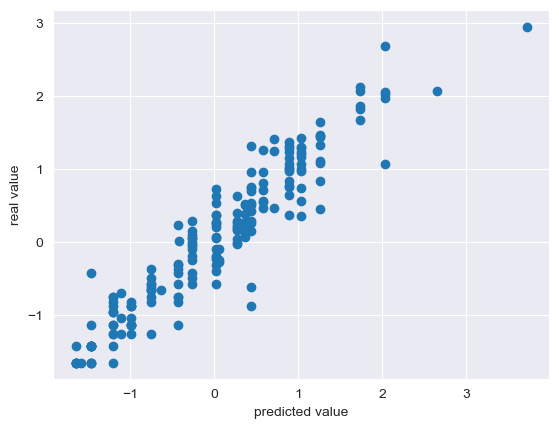

In [33]:
#chunk4:决策树
def dec_tree_reg(testsize=0.2,seed=3,max_features=3,max_depth=5):
    x=data[['nor_pledge_ratio','nor_money_pledged','nor_pledge_goal']]
    y=data['nor_back_num']

    # 拆分测试集 训练集
    x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=testsize,random_state=seed)

    dtr=DecisionTreeRegressor(max_features=max_features,max_depth=max_depth,random_state=seed)
    dtr.fit(x_train, y_train)
    pred_test_y = dtr.predict(x_test)
    #输出r-square
    a='训练集R-square: '+str(dtr.score(x_train,y_train))
    b='测试集R-square: '+str(dtr.score(x_test,y_test))

    plt.scatter(pred_test_y,y_test)
    plt.xlabel('predicted value')
    plt.ylabel('real value')
    dot_data=tree.export_graphviz(dtr,out_file=None)
    graph=graphviz.Source(dot_data)

    #todo:决策树可视化、特征重要度
    start_time=time.time()
    # 给定参数搜索范围：list or distribution
    param_dist = {"max_depth": [3,4,5,6],                     #给定list
                  "max_features": randint(1, 3),          #给定distribution
                  #"min_samples_split": randint(2, 8),     #给定distribution
                  "criterion": ["mse", "mae"]}           #给定list

    # 用RandomSearch+CV选取超参数
    n_iter_search = 20
    random_search = RandomizedSearchCV(dtr, param_distributions=param_dist,
                                       n_iter=n_iter_search, cv=5)
    random_search.fit(x, y)

    return '决策树回归',a,b,'最佳得分: ',random_search.best_score_,'最佳参数: ',random_search.best_params_,'用时: ',str(time.time()-start_time)

dec_tree_reg(testsize=0.1,seed=3,max_features=3,max_depth=5)

('bagging决策树回归',
 '训练集R-square: 0.8962292113584536',
 '测试集R-square: 0.895019592938076')

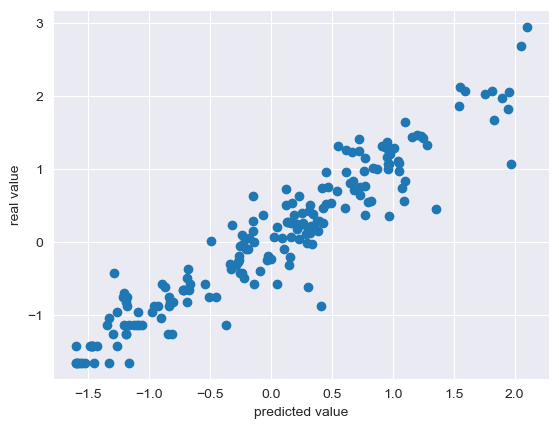

In [34]:
#chunk5:bagging
def bagging_dtr(testsize=0.2,seed=3,max_features=3,max_depth=5,n_estimators=100,max_samples=100):
    x=data[['nor_pledge_ratio','nor_money_pledged','nor_pledge_goal']]
    y=data['nor_back_num']

    # 拆分测试集 训练集
    x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=testsize,random_state=seed)

    bag_dtr=BaggingRegressor(DecisionTreeRegressor(max_features=max_features,max_depth=max_depth,random_state=seed),n_estimators=n_estimators,max_samples=max_samples,bootstrap=True,n_jobs=-1,random_state=seed)
    bag_dtr.fit(x_train,y_train)
    pred_test_y = bag_dtr.predict(x_test)
    #输出r-square
    a='训练集R-square: '+str(bag_dtr.score(x_train,y_train))
    b='测试集R-square: '+str(bag_dtr.score(x_test,y_test))

    plt.scatter(pred_test_y,y_test)
    plt.xlabel('predicted value')
    plt.ylabel('real value')
    return 'bagging决策树回归',a,b

bagging_dtr(testsize=0.1,seed=3,max_features=3,max_depth=5,n_estimators=100,max_samples=100)



('随机森林回归', '训练集R-square: 0.919974894030654', '测试集R-square: 0.9015465075685111')

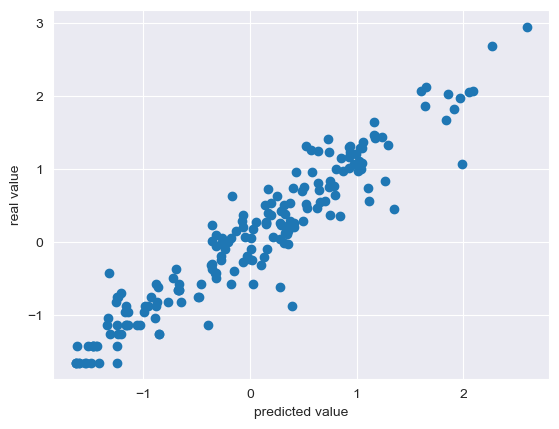

In [41]:
#chunk6:RandomForest
def ranfor_dtr(testsize=0.2,seed=3,max_features=3,max_depth=5,n_estimators=100,max_samples=100):
    x=data[['nor_pledge_ratio','nor_money_pledged','nor_pledge_goal']]
    y=data['nor_back_num']

    # 拆分测试集 训练集
    x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=testsize,random_state=seed)

    ranfor_dtr=RandomForestRegressor(n_estimators=n_estimators,max_features=max_features,max_depth=max_depth,max_samples=max_samples,bootstrap=True,n_jobs=-1,random_state=seed)
    ranfor_dtr.fit(x_train,y_train)
    pred_test_y = ranfor_dtr.predict(x_test)
    #输出r-square
    a='训练集R-square: '+str(ranfor_dtr.score(x_train,y_train))
    b='测试集R-square: '+str(ranfor_dtr.score(x_test,y_test))

    plt.scatter(pred_test_y,y_test)
    plt.xlabel('predicted value')
    plt.ylabel('real value')
    return '随机森林回归',a,b

ranfor_dtr(testsize=0.1,seed=3,max_features=3,max_depth=10,n_estimators=1000,max_samples=300)




('随机森林回归',
 '训练集R-square: 0.9016809433965088',
 '测试集R-square: 0.8977270982798669',
 '样本外R-square: 0.8655847016981344')

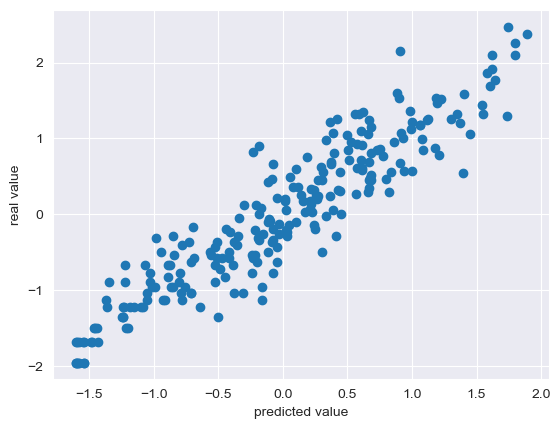

In [11]:
#样本外验证
out_of_sample_data=pd.read_csv('..\data_related/data/mid_data/res_1_filtered.csv')

def ranfor_dtr(testsize=0.2,seed=3,max_features=3,max_depth=5,n_estimators=100,max_samples=100):
    x=data[['nor_pledge_ratio','nor_money_pledged','nor_pledge_goal']]
    y=data['nor_back_num']

    oos_x=out_of_sample_data[['nor_pledge_ratio','nor_money_pledged','nor_pledge_goal']]
    oos_y=out_of_sample_data['nor_back_num']
    # 拆分测试集 训练集
    x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=testsize,random_state=seed)

    ranfor_dtr=RandomForestRegressor(n_estimators=n_estimators,max_features=max_features,max_depth=max_depth,max_samples=max_samples,bootstrap=True,n_jobs=-1,random_state=seed)
    ranfor_dtr.fit(x_train,y_train)
    pred_test_y = ranfor_dtr.predict(x_test)
    oos_pred_y=ranfor_dtr.predict(oos_x)
    #输出r-square
    a='训练集R-square: '+str(ranfor_dtr.score(x_train,y_train))
    b='测试集R-square: '+str(ranfor_dtr.score(x_test,y_test))
    c='样本外R-square: '+str(ranfor_dtr.score(oos_x,oos_y))
    '''plt.scatter(pred_test_y,y_test)
    plt.xlabel('predicted value')
    plt.ylabel('real value')'''
    plt.scatter(oos_pred_y,oos_y)
    plt.xlabel('predicted value')
    plt.ylabel('real value')
    return '随机森林回归',a,b,c

ranfor_dtr(testsize=0.1,seed=3,max_features=3,max_depth=10,n_estimators=1000,max_samples=100)





[14:08:47] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "loss", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




('xgboost集成学习回归',
 '训练集R-square: 0.9996230682189252',
 '测试集R-square: 0.853285420376864')

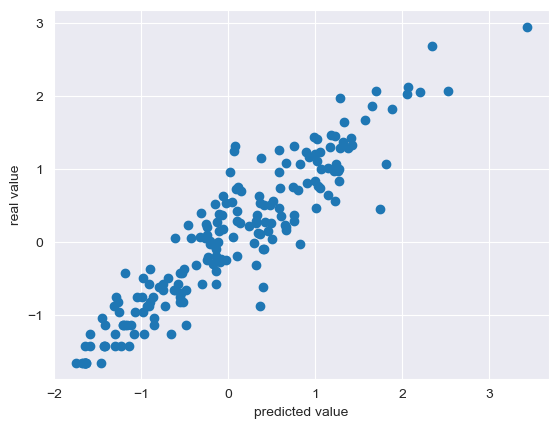

In [51]:
#chunk7:XGBoost
def xgboost_dtr(testsize=0.2,seed=3,max_features=3,max_depth=5,n_estimators=100,learning_rate=1,loss='ls'):
    x=data[['nor_pledge_ratio','nor_money_pledged','nor_pledge_goal']]
    y=data['nor_back_num']

    # 拆分测试集 训练集
    x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=testsize,random_state=seed)

    xgboost_dtr=XGBRegressor(n_estimators=n_estimators,learning_rate=learning_rate,loss=loss,random_state=seed,max_features=max_features,max_depth=max_depth)
    xgboost_dtr.fit(x_train,y_train)
    pred_test_y = xgboost_dtr.predict(x_test)
    #输出r-square
    a='训练集R-square: '+str(xgboost_dtr.score(x_train,y_train))
    b='测试集R-square: '+str(xgboost_dtr.score(x_test,y_test))

    plt.scatter(pred_test_y,y_test)
    plt.xlabel('predicted value')
    plt.ylabel('real value')
    return 'xgboost集成学习回归',a,b

xgboost_dtr(testsize=0.1,seed=3,max_features=2,max_depth=5,n_estimators=1000,learning_rate=0.8,loss='ls')


('adaboost集成学习回归',
 '训练集R-square: 0.9160891900770898',
 '测试集R-square: 0.8807461062405786')

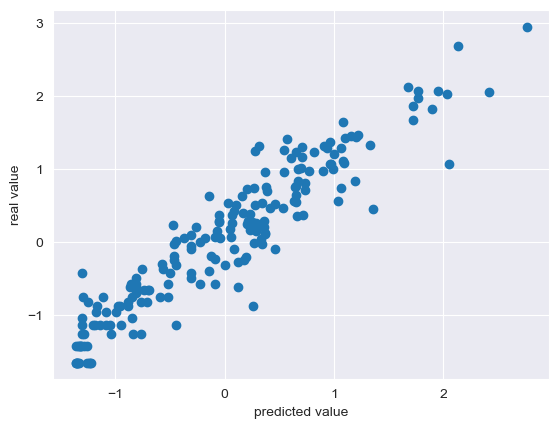

In [55]:
#chunk8:AdaBoost
def adaboost_dtr(testsize=0.2,seed=3,max_features=3,max_depth=5,n_estimators=100,learning_rate=1,loss='square'):
    x=data[['nor_pledge_ratio','nor_money_pledged','nor_pledge_goal']]
    y=data['nor_back_num']

    # 拆分测试集 训练集
    x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=testsize,random_state=seed)

    adaboost_dtr=AdaBoostRegressor(DecisionTreeRegressor(max_features=max_features,max_depth=max_depth,random_state=seed),n_estimators=n_estimators,learning_rate=learning_rate,loss=loss,random_state=seed)
    adaboost_dtr.fit(x_train,y_train)
    pred_test_y = adaboost_dtr.predict(x_test)
    #输出r-square
    a='训练集R-square: '+str(adaboost_dtr.score(x_train,y_train))
    b='测试集R-square: '+str(adaboost_dtr.score(x_test,y_test))

    plt.scatter(pred_test_y,y_test)
    plt.xlabel('predicted value')
    plt.ylabel('real value')
    return 'adaboost集成学习回归',a,b

adaboost_dtr(testsize=0.1,seed=3,max_features=3,max_depth=6,n_estimators=5000,learning_rate=0.8,loss='linear')


100%|===================| 1856/1860 [01:24<00:00]        

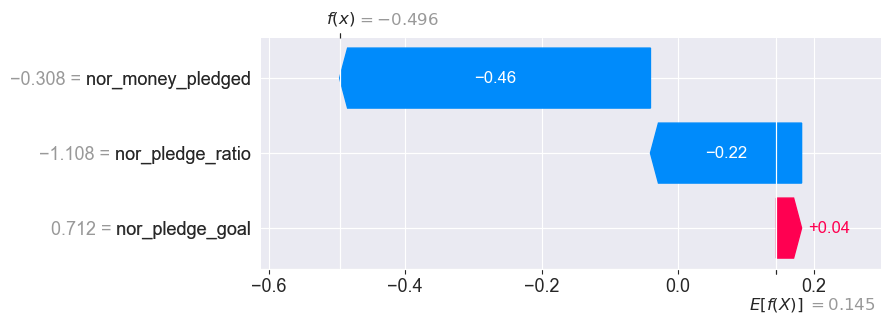

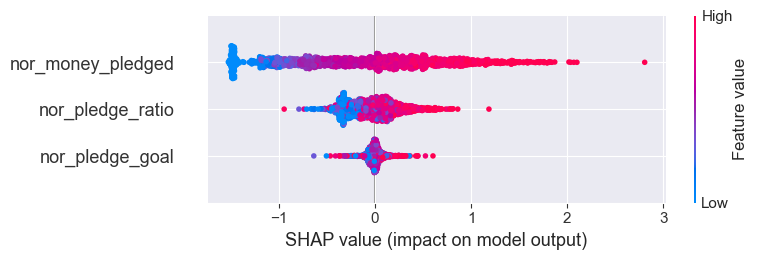

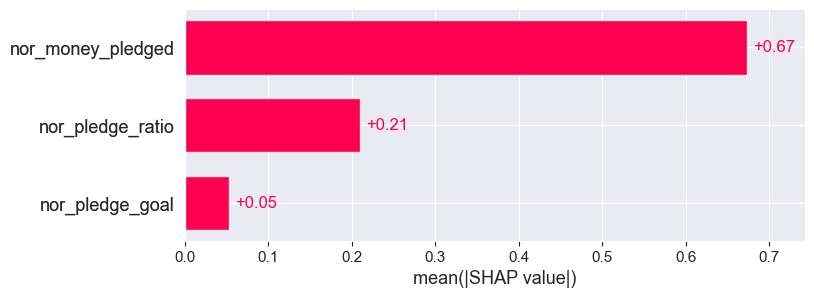

('GradientBoost集成学习回归',
 '训练集R-square: 0.9992828333897339',
 '测试集R-square: 0.880868073451954')

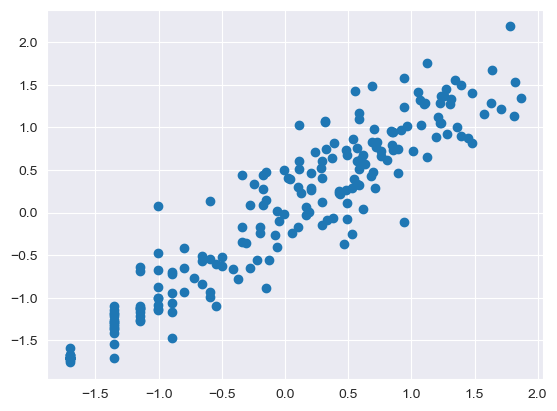

In [18]:
#chunk9:GradientBoost
def graboost_dtr(testsize=0.2,seed=3,max_features=3,max_depth=5,n_estimators=100,learning_rate=1,loss='squared_error'):
    x=data[['nor_pledge_ratio','nor_money_pledged','nor_pledge_goal']]
    y=data['nor_back_num']

    # 拆分测试集 训练集
    x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=testsize,random_state=seed)

    graboost_dtr=GradientBoostingRegressor(n_estimators=n_estimators,learning_rate=learning_rate,loss=loss,random_state=seed,max_features=max_features,max_depth=max_depth)
    model=graboost_dtr.fit(x_train,y_train)
    pred_test_y = graboost_dtr.predict(x_test)
    #输出r-square
    a='训练集R-square: '+str(graboost_dtr.score(x_train,y_train))
    b='测试集R-square: '+str(graboost_dtr.score(x_test,y_test))


    '''shap.initjs()
    explainer=shap.Explainer(model,x_train)

    shap_values=explainer(x_train)
    #print(shap_values[0])
    shap.plots.waterfall(shap_values[0])
    shap.summary_plot(shap_values,x_train)
    shap.plots.bar(shap_values)'''
    plt.scatter(y_test,pred_test_y)
    return 'GradientBoost集成学习回归',a,b

graboost_dtr(testsize=0.1,seed=3,max_features=3,max_depth=3,n_estimators=5000,learning_rate=0.5,loss='squared_error')


('stacking集成学习回归',
 '训练集R-square: 0.8642586520732276',
 '测试集R-square: 0.8700871930596221')

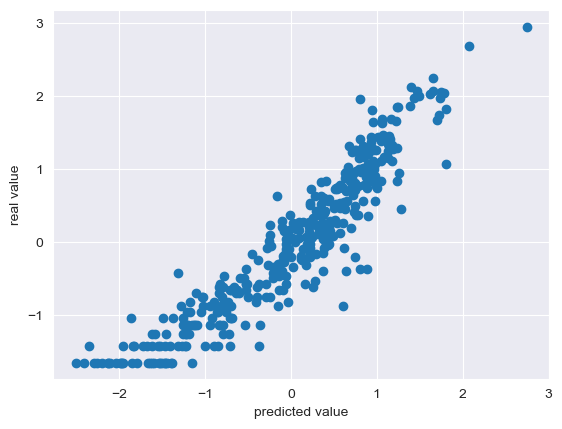

In [59]:
#chunk10:stacking
def stacking_dtr(testsize=0.2,seed=3,max_features=3,max_depth=5):
    x=data[['nor_pledge_ratio','nor_money_pledged','nor_pledge_goal']]
    y=data['nor_back_num']

    # 拆分测试集 训练集
    x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=testsize,random_state=seed)

    lr = LinearRegression()
    svr_lin = SVR(kernel='linear')
    ridge = Ridge(random_state=1)
    estimators=[('svr_lin',SVR(kernel='linear')), ('lr',LinearRegression()), ('ridge',Ridge(random_state=1))]
    stacking_dtr= StackingRegressor(estimators=estimators,final_estimator=svr_lin)
    model=stacking_dtr.fit(x_train,y_train)
    pred_test_y = stacking_dtr.predict(x_test)
    #输出r-square
    a='训练集R-square: '+str(stacking_dtr.score(x_train,y_train))
    b='测试集R-square: '+str(stacking_dtr.score(x_test,y_test))

    plt.scatter(pred_test_y,y_test)
    plt.xlabel('predicted value')
    plt.ylabel('real value')


    return 'stacking集成学习回归',a,b

stacking_dtr(testsize=0.2,seed=3,max_features=3,max_depth=6)


In [1]:
#保存依赖语句
pipreqs ./ --encoding=utf8 --force


SyntaxError: invalid syntax (1200267210.py, line 2)

In [2]:
import sklearn

sklearn.__version__

'1.1.2'

In [3]:
import fake_useragent
print(fake_useragent.__file__)

D:\anaconda\lib\site-packages\fake_useragent\__init__.py
